# Avoid negative predictions when forecasting

When training a forecasting model, despite non of the training observations being negative, it may happen that some predictions are. In order to avoid it, it is possible to model the series in logarithmic scale.

## Libraries

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
from sklearn.linear_model import Ridge
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

## Data

In [3]:
# Downloading data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url, usecols=['date_time', 'users'], nrows=1000)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()

In [4]:
# Split train-test
# ==============================================================================
end_train = '2011-01-31 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

print(f"Dates train: {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train: 2011-01-01 00:00:00 --- 2011-01-31 23:00:00  (n=744)
Dates test : 2011-02-01 00:00:00 --- 2011-02-11 15:00:00  (n=256)


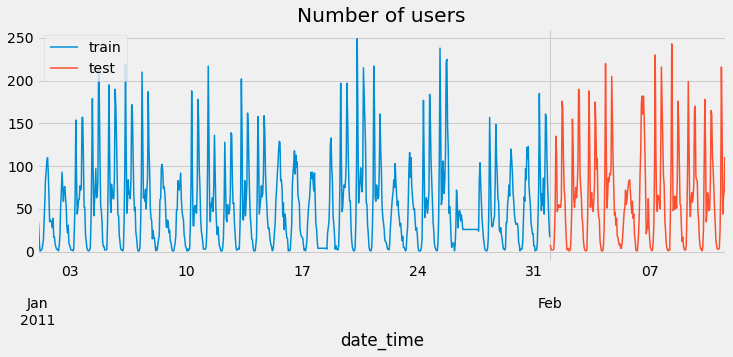

In [5]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_train['users'].plot(ax=ax, label='train')
data_test['users'].plot(ax=ax, label='test')
ax.set_title('Number of users')
ax.legend();

## Forecaster

In [6]:
# Create forecaster and train
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 24
             )

In [7]:
# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data['users'],
                        initial_train_size = len(data.loc[:end_train]),
                        fixed_train_size   = False,
                        steps              = 24,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        verbose            = False
                      )

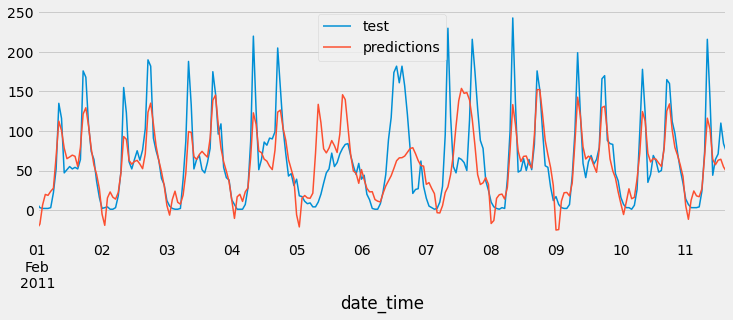

In [8]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

The plot above show that few predictions are negative.

In [9]:
# Negative predictions
predictions[predictions.pred < 0]

,pred
2011-02-01 00:00:00,-23.337236
2011-02-01 01:00:00,-17.691405
2011-02-02 00:00:00,-5.243456
2011-02-02 01:00:00,-19.363139
2011-02-03 01:00:00,-6.441943
2011-02-04 01:00:00,-10.579940
2011-02-05 00:00:00,-6.026119
2011-02-05 01:00:00,-21.396841
2011-02-07 04:00:00,-3.412043
2011-02-07 05:00:00,-3.701964


## Modeling time series in logarithmic scale

In [10]:
# Transform data into logarithmic scale
# =============================================================================
data_log = np.log1p(data)
data_train_log = np.log1p(data_train)
data_test_log  = np.log1p(data_test)

In [11]:
# Create forecaster and train
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(),
                lags          = 24,
             )

# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data_log['users'],
                        initial_train_size = len(data.loc[:end_train]),
                        fixed_train_size   = False,
                        steps              = 24,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        verbose            = False
                      )

In [12]:
# Revert the transformation
# ==============================================================================
predictions = np.expm1(predictions)
predictions.head(4)

,pred
2011-02-01 00:00:00,7.936823
2011-02-01 01:00:00,4.210682
2011-02-01 02:00:00,3.009993
2011-02-01 03:00:00,3.083922


In [13]:
metric = mean_squared_error(y_true=data_test['users'], y_pred=predictions)
print(f"Backtesting metric: {metric}")

Backtesting metric: 1991.9332571760021


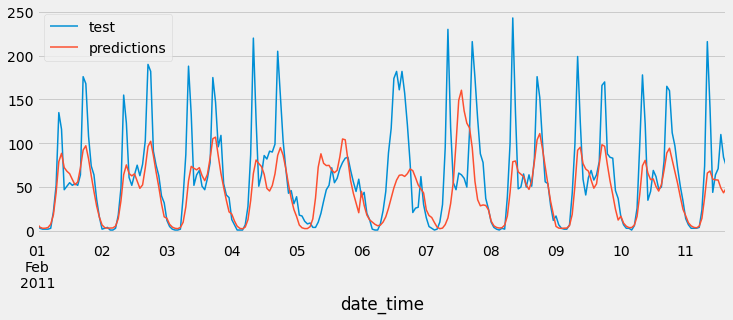

In [14]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

## Include a logarithmic transformer as part of the forecaster

Using scikit-learn [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) it is possible to include custom transformers in the forecaster object, for example, a logarithmic transformation. If the `FunctionTransformer` has an inverse function, the output of predict is automatically transformed back to the original scale.

In [15]:
# Create custom transformer
# =============================================================================
transformer_y = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

# Create forecaster and train
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(),
                lags          = 24,
                transformer_y = transformer_y
             )
forecaster.fit(data['users'])

# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data['users'],
                        initial_train_size = len(data.loc[:end_train]),
                        fixed_train_size   = False,
                        steps              = 24,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        verbose            = False
                      )
print(f"Backtesting metric: {metric}")
predictions.head()

Backtesting metric: 1991.9332571760021


,pred
2011-02-01 00:00:00,7.936823
2011-02-01 01:00:00,4.210682
2011-02-01 02:00:00,3.009993
2011-02-01 03:00:00,3.083922
2011-02-01 04:00:00,3.865169


In [16]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>